<a href="https://colab.research.google.com/github/vivekgautamgv/Python-For-Finance/blob/main/Crypto_return_%3D_36_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%%**********************]  1 of 1 completed
<ipython-input-1-1ce3dcb13f02>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Signal'][short_window:] = np.where(
<ipython-input-1-1ce3dcb13f02>:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if data['Position'][i] == 1:
<ipython-input-1-1ce3dcb13f02>:56: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif data['Position'][i] == -1 or (shares > 0 and data

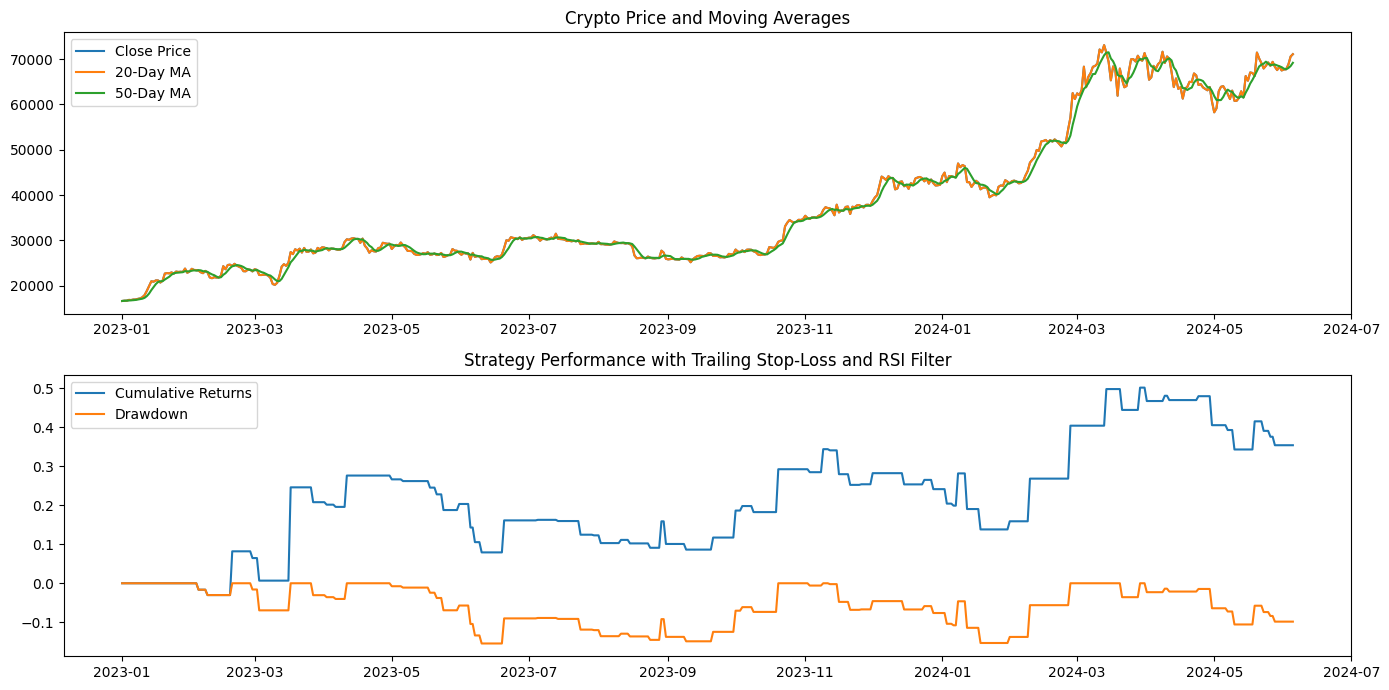

Final Return: 35.35%
Max Drawdown: 15.42%
Total Trade :  137


In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# Define parameters
symbol = 'BTC-USD'  # Crypto symbol
start_date = '2023-01-01'
end_date = '2024-06-06'
short_window = 1
long_window = 5
trailing_stop_loss = 0.10  # Trailing stop-loss at 10%
rsi_period = 10 #14
rsi_overbought = 75 #70
rsi_oversold = 32#30
trade_count = 0;

# Download historical data
data = yf.download(symbol, start=start_date, end=end_date)
data['Short_MA'] = data['Close'].rolling(window=short_window, min_periods=1).mean()
data['Long_MA'] = data['Close'].rolling(window=long_window, min_periods=1).mean()

# Calculate RSI
delta = data['Close'].diff(1)
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=rsi_period, min_periods=1).mean()
avg_loss = loss.rolling(window=rsi_period, min_periods=1).mean()
rs = avg_gain / avg_loss
data['RSI'] = 100 - (100 / (1 + rs))

# Generate trading signals
data['Signal'] = 0
data['Signal'][short_window:] = np.where(
    (data['Short_MA'][short_window:] > data['Long_MA'][short_window:]) &
    (data['RSI'][short_window:] < rsi_overbought),
    1, 0)
data['Position'] = data['Signal'].diff()

# Backtesting the strategy with trailing stop-loss
initial_capital = 10000
shares = 0
capital = initial_capital
position = 0
equity = []
stop_loss_price = 0

for i in range(len(data)):
    if data['Position'][i] == 1:
        # Buy
        shares = capital / data['Close'][i]
        position = shares * data['Close'][i]
        capital = 0
        stop_loss_price = data['Close'][i] * (1 - trailing_stop_loss)
        trade_count += 1
    elif data['Position'][i] == -1 or (shares > 0 and data['Close'][i] < stop_loss_price):
        # Sell or Stop-loss triggered
        capital = shares * data['Close'][i]
        shares = 0
        position = 0
        trade_count += 1
    elif shares > 0:
        # Update trailing stop-loss
        stop_loss_price = max(stop_loss_price, data['Close'][i] * (1 - trailing_stop_loss))

    equity.append(capital + position)

data['Equity'] = equity

# Ensure equity is never zero to avoid division by zero
data['Equity'] = data['Equity'].replace(0, np.nan).fillna(method='ffill')

# Calculate returns and drawdown
data['Returns'] = data['Equity'].pct_change().fillna(0)  # Replace NaN returns with 0
data['Cumulative_Returns'] = (1 + data['Returns']).cumprod() - 1
data['Drawdown'] = data['Equity'] / data['Equity'].cummax() - 1

# Handle case where no trades occur
if data['Equity'].iloc[-1] == initial_capital:
    final_return = 0.0
    max_drawdown = 0.0
else:
    final_return = data['Cumulative_Returns'].iloc[-1]
    max_drawdown = data['Drawdown'].min()

# Plot results
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
plt.plot(data.index, data['Close'], label='Close Price')
plt.plot(data.index, data['Short_MA'], label='20-Day MA')
plt.plot(data.index, data['Long_MA'], label='50-Day MA')
plt.title('Crypto Price and Moving Averages')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(data.index, data['Cumulative_Returns'], label='Cumulative Returns')
plt.plot(data.index, data['Drawdown'], label='Drawdown')
plt.title('Strategy Performance with Trailing Stop-Loss and RSI Filter')
plt.legend()

plt.tight_layout()
plt.show()

# Print final results
print(f"Final Return: {final_return * 100:.2f}%")
print(f"Max Drawdown: {-max_drawdown * 100:.2f}%")
print("Total Trade : ",trade_count)
